In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import zscore, norm
import numpy as np
import seaborn as sns
import time

print(pd.__version__) #1.2.4
print(sns.__version__) #0.11.1


current_path = os.getcwd()
save_to_path = os.path.join(current_path,'presentazione/pictures')

1.2.4
0.11.1


In [3]:
# !!!! 'data_challenge.xlsx' and this ipynb must be located at the same path !!!
# data_challenge_file = os.path.join(current_path, 'data_challenge.xlsx')
# CAL500_xlsx = pd.read_excel(data_challenge_file, sheet_name=0) #takes 8.3s
# VAL_HSI_xlsx = pd.read_excel(data_challenge_file, sheet_name=1)  #takes 2m50.2s

# CAL500 = CAL500_xlsx
# VAL_HSI = VAL_HSI_xlsx

# #################################### #
# conversion in csv to save time #
###################################### #

# CAL500_xlsx.to_csv(os.path.join(current_path, 'CAL500.csv'))
# VAL_HSI_xlsx.to_csv(os.path.join(current_path, 'VAL_HSI.csv'))  
CAL500_csv = pd.read_csv(os.path.join(current_path, 'CAL500.csv'))
VAL_HSI_csv = pd.read_csv(os.path.join(current_path, 'VAL_HSI.csv'))
CAL500 = CAL500_csv
VAL_HSI = VAL_HSI_csv

# takes 3m 28.2s

In [3]:
# plot spectra
for i in range(len(CAL500)):
    plt.plot(CAL500.drop(['Yref','Unnamed: 0'], axis=1).keys().astype(float), CAL500.drop(['Yref','Unnamed: 0'], axis=1).iloc[i], color='red')
for i in range(0, len(VAL_HSI), 80):
    plt.plot(VAL_HSI.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 1'], axis=1).keys().astype(float), VAL_HSI.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 1'], axis=1).iloc[i], color='blue')


: 

: 

In [4]:
from scipy.interpolate import interp1d # import interpolation function to have same independent variables training/eval sets
 
X_cal500 = CAL500.drop(['Yref', 'Unnamed: 0'], axis=1).keys().astype(float) # get wavelengths values for training set
len_Y_cal500 = len(CAL500.drop(['Yref'], axis=1).iloc[:, 1]) # get number of samples for training set

X_val_hsi = VAL_HSI.drop(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 0.1'], axis=1).keys().astype(float) # get wavelenghts values for unknown set
len_Y_val_hsi = len(VAL_HSI.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1).iloc[:, 1]) # get number of samples for unknown set

# add astype(float) if xls file loaded instead of csv; Unnamed 0 column not removed from CAL500; 'Unnamed: 0.1' not removed from VALHSI

In [5]:
# interpolation in order to have training set with same wavelenght as unknown set
new_Y_cal500 = []
for i in range(0, len_Y_cal500):
    interpolated_val = []
    Y_cal500 = CAL500.drop(['Yref','Unnamed: 0'], axis=1).iloc[i]
    y_interp = interp1d(X_cal500, Y_cal500, kind='linear', bounds_error=False, fill_value=0)
    for unknown in X_val_hsi:
        interpolated_val.append(float(y_interp(unknown)))
    new_Y_cal500.append(interpolated_val)
## takes 27m 37.3s
## takes 2m 58.6s
## takes 5.5s

In [6]:
new_data_frame = pd.DataFrame(columns = X_val_hsi.astype(float), index = range(0,len(new_Y_cal500)))
for i in range(len(new_Y_cal500)):
    new_data_frame.iloc[i] = new_Y_cal500[i] 
new_data_frame = new_data_frame.loc[:, (new_data_frame != 0).any(axis=0)]
# takes 28.1s
# takes 0.2s

In [7]:
from sklearn.model_selection import train_test_split

X = new_data_frame
y = CAL500['Yref']
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape)
print(y_train.shape)
y_val = VAL_HSI.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 1'], axis=1)

(375, 209)
(375,)


In [9]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score

pca = PLSRegression()

X_reduced = pca.fit_transform(scale(X))
n = len(X_reduced)

kf_10 = KFold( n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# # Calculate MSE using CV for the 19 principle components, adding one component at the time.
# for i in np.arange(1, 30):
#     score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
#     mse.append(score)
    
# # Plot results    
# plt.plot(mse, '-v')
# plt.xlabel('Number of principal components in regression')
# plt.ylabel('MSE')
# plt.xlim(xmin=-1)

(-1.0, 19.9)

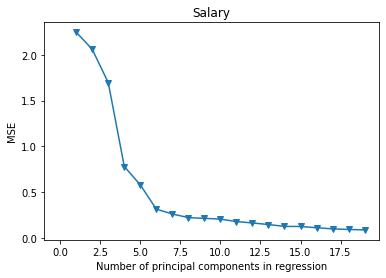

In [143]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)

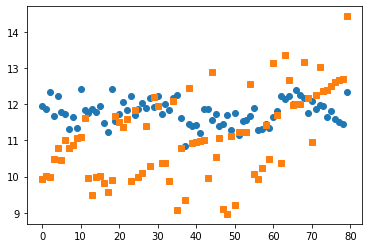

(1.345434398175034, 0.02124563732699417)


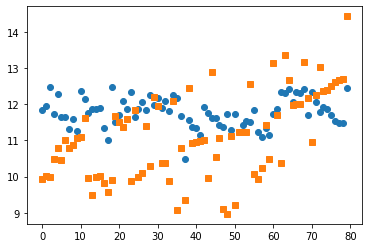

(1.3336675934567588, 0.04259606463569305)


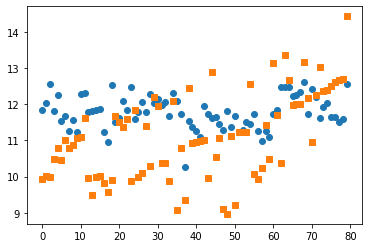

(1.324542056180435, 0.06067223639708816)


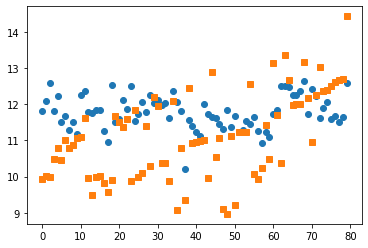

(1.3216905554664644, 0.06581109605935939)


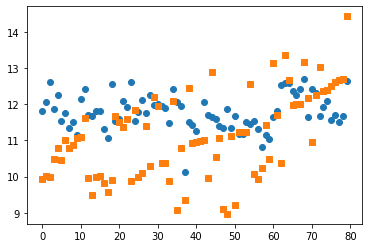

(1.3231766515447345, 0.06798270469056937)


In [173]:
def Get_SG_evaluation(data):
    actual_values = np.loadtxt(os.path.join(current_path, 'Actual_val.csv'), usecols=1, skiprows = True)
    rmsqe = np.sqrt(mean_squared_error(actual_values, data))
    corr_matrix = np.corrcoef(actual_values, data)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    plt.plot(data, linestyle='none', marker = 'o')
    plt.plot(actual_values, linestyle='none', marker = 's')
    plt.show()
    plt.close()
    return rmsqe, R_sq

mse = []
r2 = []
for n_components in range(20, 25):
    pls = PLSRegression(n_components)
    pls.fit(scale(X_train), y_train)
    mean_squared_error(y_test, pls.predict(scale(X_test)))
    fin_val_pls = pls.predict(scale(y_val))
    final_averaged_result_pls = np.average(fin_val_pls.reshape(400,80),axis=0)
    print(Get_SG_evaluation(final_averaged_result_pls))